
### **Instructions**


1.   Run **Downloading 'punkt'** first if you're here for the first time.
2.   Run the training module to train the model and plot the learning graph.
3.   Run the implementation module for the chatbot.



### **Downloading 'punkt'**

Run this first if you're here for the first time!

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### **Utility Functions**

Functions for Tokenizing, Stemming and Bag of Words are defined here


In [ ]:
import numpy as np
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
  
# lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def tokenize(sentence):
    #tokenization
    return nltk.word_tokenize(sentence)
    


def stem(word):
    #stemming after converting to lower case
    return stemmer.stem(word.lower())
    # return lemmatizer.lemmatize(word.lower())
    


def bag_of_words(tokenized_sentence, words):
    # stem each word
    sentence_words = [stem(word) for word in tokenized_sentence]
    # initialize bag with 0 for each word
    bag = np.zeros(len(words), dtype=np.float32)
    for idx, w in enumerate(words):
        if w in sentence_words: 
            bag[idx] = 1
    return bag


# [how,are,you] - tok
# [what,are,you,doing,how] - words

# bag = [0,1,1,0,1] = 1hot encoded vector

### **Creating a Neural Network Model**

A Feed Forward Neural Network Model is created here




In [ ]:
import torch
import torch.nn as nn


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.l2 = nn.Linear(hidden_size, hidden_size) 
        self.l3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        return out

### **Plotting the Loss Graph**

After training, a Loss vs Epoch graph is plotted here

In [ ]:
import matplotlib.pyplot as plt


def plot_learning_curve(learning_data):
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Model Loss Plot")

    plt.plot(learning_data['epoch values'], learning_data['loss values'], label = 'loss curve')
    plt.legend(loc = "upper right")
  



### **Training the Model using the sample set**

The model is trained using the sample patterns given in intents.json

30 patterns
7 tags: ['aboutbot', 'casualchatbot', 'funny', 'goodbye', 'greeting', 'thanks', 'treatments']
50 unique stemmed words: ["'s", 'a', 'anyon', 'are', 'bye', 'can', 'day', 'depress', 'distract', 'do', 'escap', 'everyth', 'feel', 'from', 'funni', 'go', 'good', 'goodby', 'happi', 'hello', 'help', 'hey', 'hi', 'how', 'i', 'is', 'it', 'joke', 'know', 'later', 'lot', 'make', 'me', 'myself', 'see', 'should', 'someth', 'tell', 'thank', 'that', 'there', 'thi', 'to', 'treat', 'up', 'voic', 'what', 'who', 'you', 'your']
50 7
Epoch [100/1000], Loss: 0.9314
Epoch [200/1000], Loss: 0.2351
Epoch [300/1000], Loss: 0.0376
Epoch [400/1000], Loss: 0.0091
Epoch [500/1000], Loss: 0.0153
Epoch [600/1000], Loss: 0.0033
Epoch [700/1000], Loss: 0.0030
Epoch [800/1000], Loss: 0.0014
Epoch [900/1000], Loss: 0.0009
Epoch [1000/1000], Loss: 0.0015
final loss: 0.0015
training complete. file saved to data.pth


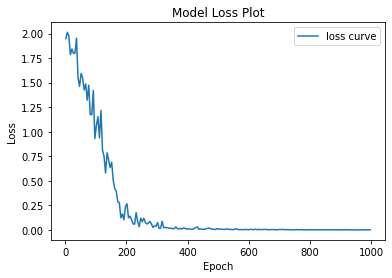

In [ ]:
import numpy as np
import random
import json
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


from MHH.nltk_utils import bag_of_words, tokenize, stem
from MHH.model import NeuralNet
from MHH.learning_curve import plot_learning_curve

with open('MHH/intents.json', 'r') as f:
    intents = json.load(f)

all_words = []
tags = [] 
xy = []
# loop through each sentence in our intents patterns
for intent in intents['intents']:
    tag = intent['tag']
    # add to tag list
    tags.append(tag)
    for pattern in intent['patterns']:
        # tokenize each word in the sentence
        w = tokenize(pattern)
        # add to our words list
        all_words.extend(w)
        # add to xy pair
        xy.append((w, tag))

# stem and lower each word
ignore_words = ['?', '.', '!']
all_words = [stem(w) for w in all_words if w not in ignore_words]
# remove duplicates and sort
all_words = sorted(set(all_words))
tags = sorted(set(tags))

print(len(xy), "patterns")
print(len(tags), "tags:", tags)
print(len(all_words), "unique stemmed words:", all_words)

# create training data
X_train = []
y_train = []
for (pattern_sentence, tag) in xy:
    # X: bag of words for each pattern_sentence
    bag = bag_of_words(pattern_sentence, all_words)
    X_train.append(bag)
    # y: PyTorch CrossEntropyLoss needs only class labels, not one-hot
    label = tags.index(tag)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Hyper-parameters 
num_epochs = 1000
batch_size = 8
learning_rate = 0.001
input_size = len(X_train[0])
hidden_size = 8
output_size = len(tags)
print(input_size, output_size)

class ChatDataset(Dataset):

    def __init__(self):
        self.n_samples = len(X_train)
        self.x_data = X_train
        self.y_data = y_train

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

dataset = ChatDataset()
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NeuralNet(input_size, hidden_size, output_size).to(device)
y = np.zeros(200)
x = np.array([i+1 for i in range(1,1001,5)])
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
counter = 0
# Train the model
for epoch in range(num_epochs):
    for (words, labels) in train_loader:
        words = words.to(device)
        labels = labels.to(dtype=torch.long).to(device)
        
        # Forward pass
        outputs = model(words)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 100 == 0:
        print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    if (epoch+1) % 5 == 0:
        y[counter] = loss.item()
        counter = counter + 1

# Plotting the graph

# print("Loss vs Epoch Graph:")

# plt.plot(x,y)

learning_data = {
    'epoch values': x,
    'loss values': y
}
plot_learning_curve(learning_data)


print(f'final loss: {loss.item():.4f}')

data = {
"model_state": model.state_dict(),
"input_size": input_size,
"hidden_size": hidden_size,
"output_size": output_size,
"all_words": all_words,
"tags": tags
}

FILE = "data.pth"
torch.save(data, FILE)

print(f'training complete. file saved to {FILE}')





# """
# Set the gradients to zero before backpropogation because pytorch accumulates the gradients while backtracking
# """


### **Implementing a chatbot using the trained model**

And finally, the responses are displayed using the model we trained in the previous step.

In [ ]:

import random
import json

import torch

from MHH.model import NeuralNet
from MHH.nltk_utils import bag_of_words, tokenize

device = torch.device('cpu')
sys_random = random.SystemRandom()

with open('MHH/intents.json', 'r') as json_data:
    intents = json.load(json_data)

FILE = "data.pth"
data = torch.load(FILE)

input_size = data["input_size"]
hidden_size = data["hidden_size"]
output_size = data["output_size"]
all_words = data['all_words']
tags = data['tags']
model_state = data["model_state"]

model = NeuralNet(input_size, hidden_size, output_size).to(device)
model.load_state_dict(model_state)
model.eval()

bot_name = input("Give me a name:")
print(f"I'm {bot_name}, your virtual mental health helper!! Let's chat! (type 'quit' to exit)")
while True:
    sentence = input("You: ")
    if sentence == "quit":
        break

    sentence = tokenize(sentence)
    X = bag_of_words(sentence, all_words)
    X = X.reshape(1, X.shape[0])
    X = torch.from_numpy(X).to(device)
    output = model(X)
    _, predicted = torch.max(output, dim=1) #unpacking tuples

    tag = tags[predicted.item()] 

    probs = torch.softmax(output, dim=1)
    prob = probs[0][predicted.item()]
    #print(prob.item())
    if prob.item() > 0.9:
        for intent in intents['intents']:
            if tag == intent["tag"]:
                print(f"{bot_name}: {sys_random.choice(intent['responses'])}")
    else:
        print(f"{bot_name}: I do not understand...")







        

Give me a name:HelpBot
I'm HelpBot, your virtual mental health helper!! Let's chat! (type 'quit' to exit)
You: Hi
HelpBot: Hey :-)
You: Who are you?
HelpBot: I am just someone you can talk to if your friends are busy!! But again, I'm just a bot and it's always better to have a conversation with real people you trust!!
You: Can you help me with depression?
HelpBot: I am your virtual mental health helper and I can help you get a clear idea of what's really going on!!
You: What can you do?
HelpBot: I am just someone you can talk to if your friends are busy!! But again, I'm just a bot and it's always better to have a conversation with real people you trust!!
You: How to treat depression?
HelpBot: Open up to a loved one and try to spend more time in doing things you love!!
You: Do you know something funny?
HelpBot: What did the buffalo say when his son left for college? Bison.
You: Thank you
HelpBot: My pleasure
You: bye
HelpBot: Bye! Come back again soon.
You: quit


### For Downloading the files

In [ ]:
!zip -r /content/MHH.zip /content/MHH